In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [50]:
data = pd.read_csv('ai4i2020.csv')

In [51]:
data

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


We are going to use the CRISP-DM Method for our project. According to that the first step is to understand the goal of the project. 

1. GOAL SETTING

GOAL - > The goal of our project is to apply this structred approched to reduce downtime and operational cost of the manufaccturing unit by properly scheduling timely maintenanace. The dataset contains various feature which can be important for the model development and might also have to feature engineer. By analyzing these features, We aim to identify potential failures before they occur, allowing for proactive maintenance actions. This will contribute to more efficient machine management and prevent unexpected failures, improving the overall productivity of the manufacturing process

2. DATA CLEANING

The second step of the project is to gain a thorough understanding of the data, clean it, and organize it into a structured database.

In [52]:
data.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [53]:
print('DATA EXPLORATION\n\n',data.describe())
print("\n\n")
print('NULL VALUES\n\n', data.isnull().sum())
print("\n\n")
duplicates = data.duplicated()
print("NUMBER OF DUPLICATES\n\n",duplicates.sum())
print("\n\n")
print("DATA TYPES\n\n", data.dtypes)

DATA EXPLORATION

                UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  Machine failure  \
count            10000.000000  10000.000000     10000.000000     10000.000000   
mean              1538.776100     39.986910       107.951000         0.033900   
std                179.284096      9.968934        63.654147         0.180981   
min               1168.000000      3.800000 

In [54]:
columns_to_drop = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
data = data.drop(columns=columns_to_drop)
data.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,1,M14860,M,298.1,308.6,1551,42.8,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0


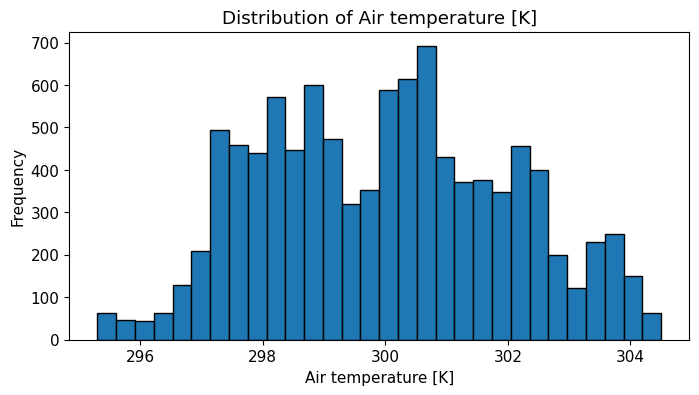

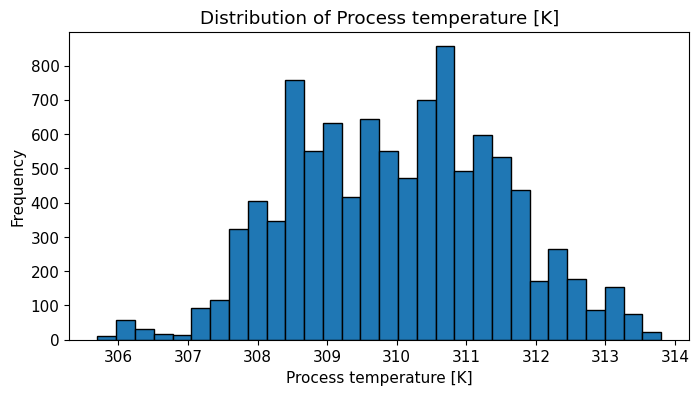

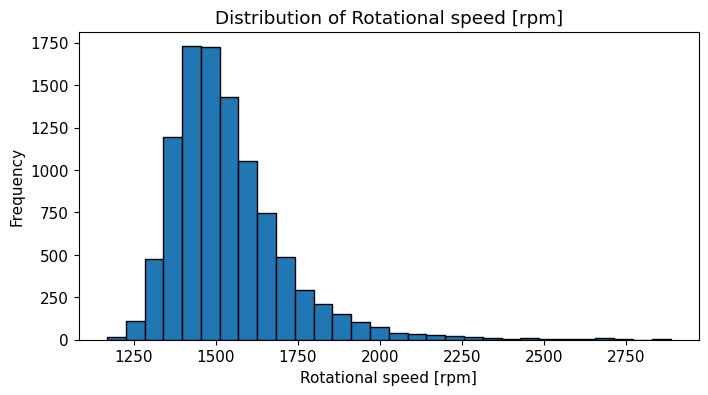

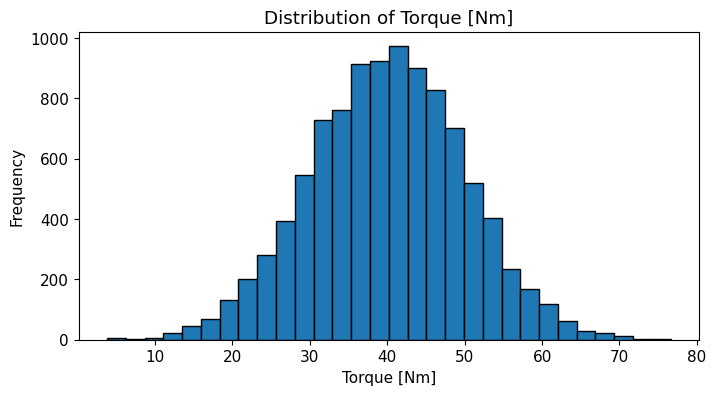

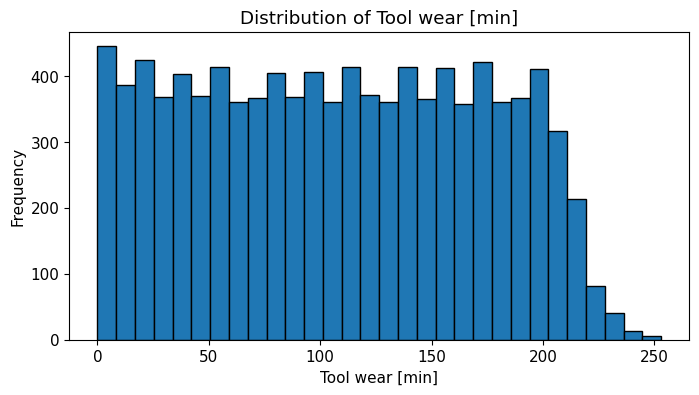

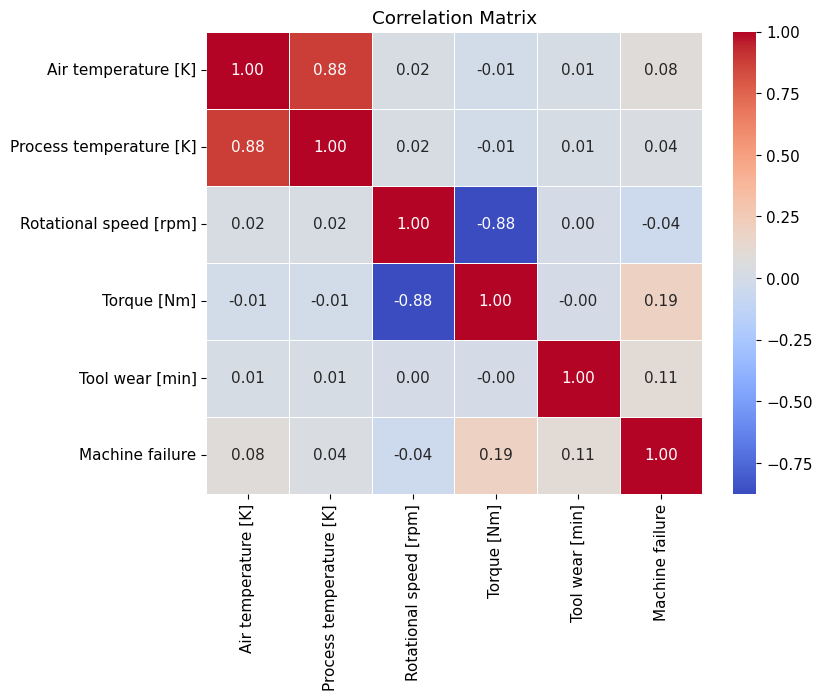

In [55]:
# Select the sensor/process metrics (exclude IDs, types, and failure flags)
metric_cols = [
    col for col in data.select_dtypes(include=[np.number]).columns
    if col not in [
        'UDI',          # unique ID
        'Machine failure',  # target
        'TWF','HDF','PWF','OSF','RNF'  # failure subtypes
    ]
]

# Plot histograms for each metric column
for col in metric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(data[col].dropna(), bins=30, edgecolor='black')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Plot the correlation matrix
features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 
            'Tool wear [min]', 'Machine failure']
correlation_matrix = data[features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Correlation with Machine Failure

- **Air temperature [K]**: 0.08
- **Process temperature [K]**: 0.04
- **Rotational speed [rpm]**: -0.04
- **Torque [Nm]**: 0.19
- **Tool wear [min]**: 0.11


In [56]:
X = data[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
          'Torque [Nm]', 'Tool wear [min]']]
y = data['Machine failure']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
y_prob = rf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc_score)
cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print(f"Cross-validated AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.43      0.78      0.56        68

    accuracy                           0.96      2000
   macro avg       0.71      0.87      0.77      2000
weighted avg       0.97      0.96      0.96      2000

AUC-ROC Score: 0.9636501339666301
Cross-validated AUC-ROC: 0.9971 ± 0.0007


The **AUC-ROC score of 0.96** indicates that the model is excellent at distinguishing between the two classes, **failure (class 1)** and **non-failure (class 0)**. This high score suggests that the model is performing very well at classifying both types of outcomes, with a strong ability to separate the two classes.

In [57]:
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                   Feature           VIF
0      Air temperature [K]  87413.106376
1  Process temperature [K]  88285.242860
2   Rotational speed [rpm]    315.329872
3              Torque [Nm]     72.125192
4          Tool wear [min]      3.877244


In [58]:
y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))
y_prob = rf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc_score)
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print(f"Cross-validated AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.43      0.78      0.56        68

    accuracy                           0.96      2000
   macro avg       0.71      0.87      0.77      2000
weighted avg       0.97      0.96      0.96      2000

AUC-ROC Score: 0.9636501339666301
Cross-validated AUC-ROC: 0.9971 ± 0.0007


Visual Summary for Random Forest Classification

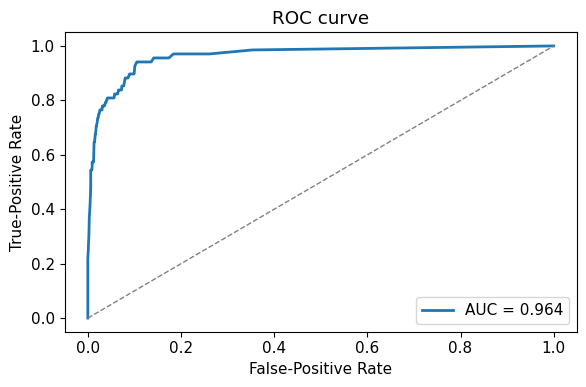

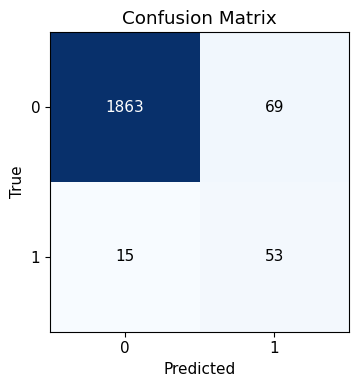

In [59]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 11

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], ls="--", lw=1, color="gray")
plt.xlabel("False-Positive Rate");  plt.ylabel("True-Positive Rate")
plt.title("ROC curve");             plt.legend();  plt.tight_layout()
plt.show()

# Confusion-matrix heat-map
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xlabel("Predicted");  ax.set_ylabel("True")
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")
plt.title("Confusion Matrix");  plt.tight_layout();  plt.show()




In [60]:
pca = PCA(n_components=1)  # Reduce to a single component
X['Temperature_Component'] = pca.fit_transform(X[['Air temperature [K]', 'Process temperature [K]']])

X = X.drop(columns=['Air temperature [K]', 'Process temperature [K]'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

y_prob = rf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc_score)

cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print(f"Cross-validated AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

C:\Users\varun\AppData\Local\Temp\ipykernel_20676\1368270294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Temperature_Component'] = pca.fit_transform(X[['Air temperature [K]', 'Process temperature [K]']])


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1932
           1       0.35      0.76      0.48        68

    accuracy                           0.94      2000
   macro avg       0.67      0.86      0.73      2000
weighted avg       0.97      0.94      0.95      2000

AUC-ROC Score: 0.9465541651443186
Cross-validated AUC-ROC: 0.9936 ± 0.0004


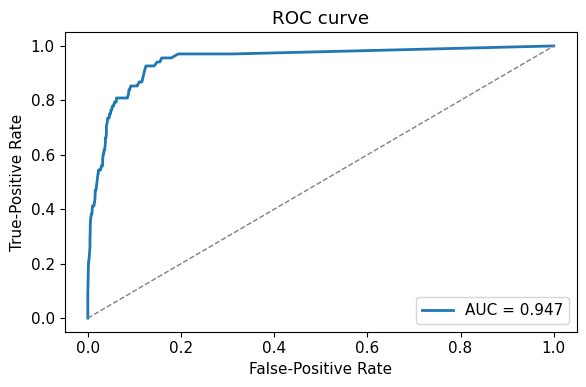

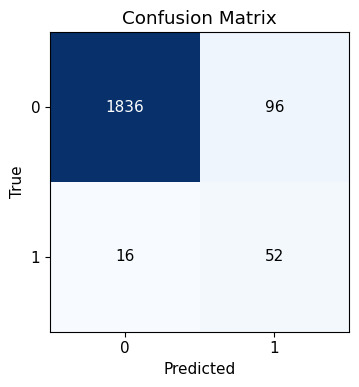

In [61]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 11

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], ls="--", lw=1, color="gray")
plt.xlabel("False-Positive Rate");  plt.ylabel("True-Positive Rate")
plt.title("ROC curve");             plt.legend();  plt.tight_layout()
plt.show()

# Confusion-matrix heat-map
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xlabel("Predicted");  ax.set_ylabel("True")
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")
plt.title("Confusion Matrix");  plt.tight_layout();  plt.show()




In [62]:
data['Temp_diff'] = data['Process temperature [K]'] - data['Air temperature [K]']

X = data[['Temp_diff', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]  # Required columns for features
y = data['Machine failure']  # Target variable

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

y_pred = rf.predict(X_test)

from sklearn.metrics import classification_report
print("Classification Report:\n", classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score
y_prob = rf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("AUC-ROC Score:", auc_score)

from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(rf, X_train_resampled, y_train_resampled, cv=5, scoring='roc_auc')
print(f"Cross-validated AUC-ROC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.45      0.84      0.58        68

    accuracy                           0.96      2000
   macro avg       0.72      0.90      0.78      2000
weighted avg       0.98      0.96      0.97      2000

AUC-ROC Score: 0.9633076056509562
Cross-validated AUC-ROC: 0.9967 ± 0.0007


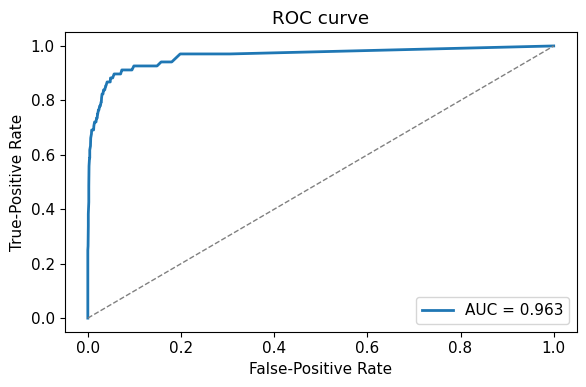

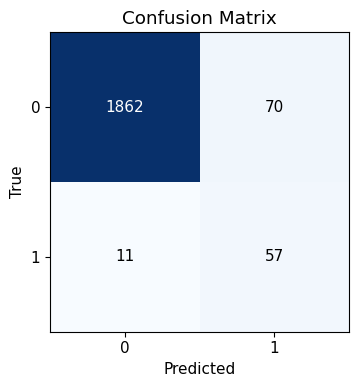

In [63]:
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["font.size"] = 11

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], ls="--", lw=1, color="gray")
plt.xlabel("False-Positive Rate");  plt.ylabel("True-Positive Rate")
plt.title("ROC curve");             plt.legend();  plt.tight_layout()
plt.show()

# Confusion-matrix heat-map
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xlabel("Predicted");  ax.set_ylabel("True")
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black")
plt.title("Confusion Matrix");  plt.tight_layout();  plt.show()


